# EDA & Machine Learning for predicting employee size for ships
##### Author: Tareq Galala

## Objective: 
#### Build a machine learning model that recommends the number of employees for potential ship buyers, so that they know how many people they have to hire to crew the ship.

### Import Libraries

In [313]:
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from pprint import pprint
import shap

warnings.filterwarnings('ignore')
%matplotlib inline
sns.set(style="ticks", color_codes=True)

### Load Data

In [314]:
# Reading csv file using pandas. 
# Alternative way is to set ship name as index
df=pd.read_csv("ship_info.csv")

In [315]:
display(df)

,Ship_name,Company,Age,Weight,passengers,length,cabins,passenger_density,employees
0,Journey,Azamara,6,30.277,6.94,5.94,3.55,42.64,3.55
1,Quest,Azamara,6,30.277,6.94,5.94,3.55,42.64,3.55
2,Celebration,Carnival,26,47.262,14.86,7.22,7.43,31.80,6.70
3,Conquest,Carnival,11,110.000,29.74,9.53,14.88,36.99,19.10
4,Destiny,Carnival,17,101.353,26.42,8.92,13.21,38.36,10.00
...,...,...,...,...,...,...,...,...,...
153,Taurus,Star,22,3.341,0.66,2.79,0.33,50.62,0.59
154,Virgo,Star,14,76.800,19.60,8.79,9.67,39.18,12.00
155,Spirit,Windstar,25,5.350,1.58,4.40,0.74,33.86,0.88
156,Star,Windstar,27,5.350,1.67,4.40,0.74,32.04,0.88


In [316]:
# Print number of ships and columns/features/labels
print ('Data has ' + str(df.shape[0]) + ' ships & ' + str(df.shape[1]) + ' features.')

Data has 158 ships & 9 features.


### Exploratory Data Analysis (EDA)

In [317]:
# Print featues
df.columns

Index(['Ship_name', 'Company', 'Age', 'Weight', 'passengers', 'length',
       'cabins', 'passenger_density', 'employees'],
      dtype='object')

In [318]:
# Check for nulls and types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158 entries, 0 to 157
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Ship_name          158 non-null    object 
 1   Company            158 non-null    object 
 2   Age                158 non-null    int64  
 3   Weight             158 non-null    float64
 4   passengers         158 non-null    float64
 5   length             158 non-null    float64
 6   cabins             158 non-null    float64
 7   passenger_density  158 non-null    float64
 8   employees          158 non-null    float64
dtypes: float64(6), int64(1), object(2)
memory usage: 11.2+ KB


In [319]:
# Check for duplicates
df.duplicated().sum()

0

Comment: <BR>
Great! No missing data/Nulls or duplicates. The dataset contains two categorical features/columns which are Ship name and Company. The remaining columns are numerical.

In [320]:
# Lets look at some statistics for the numerical columns
df.describe()

,Age,Weight,passengers,length,cabins,passenger_density,employees
count,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000
mean,15.689873,71.284671,18.457405,8.130633,8.830000,39.900949,7.794177
std,7.615691,37.229540,9.677095,1.793474,4.471417,8.639217,3.503487
min,4.000000,2.329000,0.660000,2.790000,0.330000,17.700000,0.590000
25%,10.000000,46.013000,12.535000,7.100000,6.132500,34.570000,5.480000
50%,14.000000,71.899000,19.500000,8.555000,9.570000,39.085000,8.150000
75%,20.000000,90.772500,24.845000,9.510000,10.885000,44.185000,9.990000
max,48.000000,220.000000,54.000000,11.820000,27.000000,71.430000,21.000000


Comment: <BR>
Above is a display for the most important statistics. The min, max and quarantiles which indicates a fairly distrubuted data points. <Br>
No need for scaling or standardization. Normalization is useful when your data has varying scales and planning to use sensitive models to they variations. <Br>
Since we are are planning to model with Random forest and XGB, which are information based ensemblre algorithms comprised of decision trees, they do not require <Br>
normalization for the inputs.

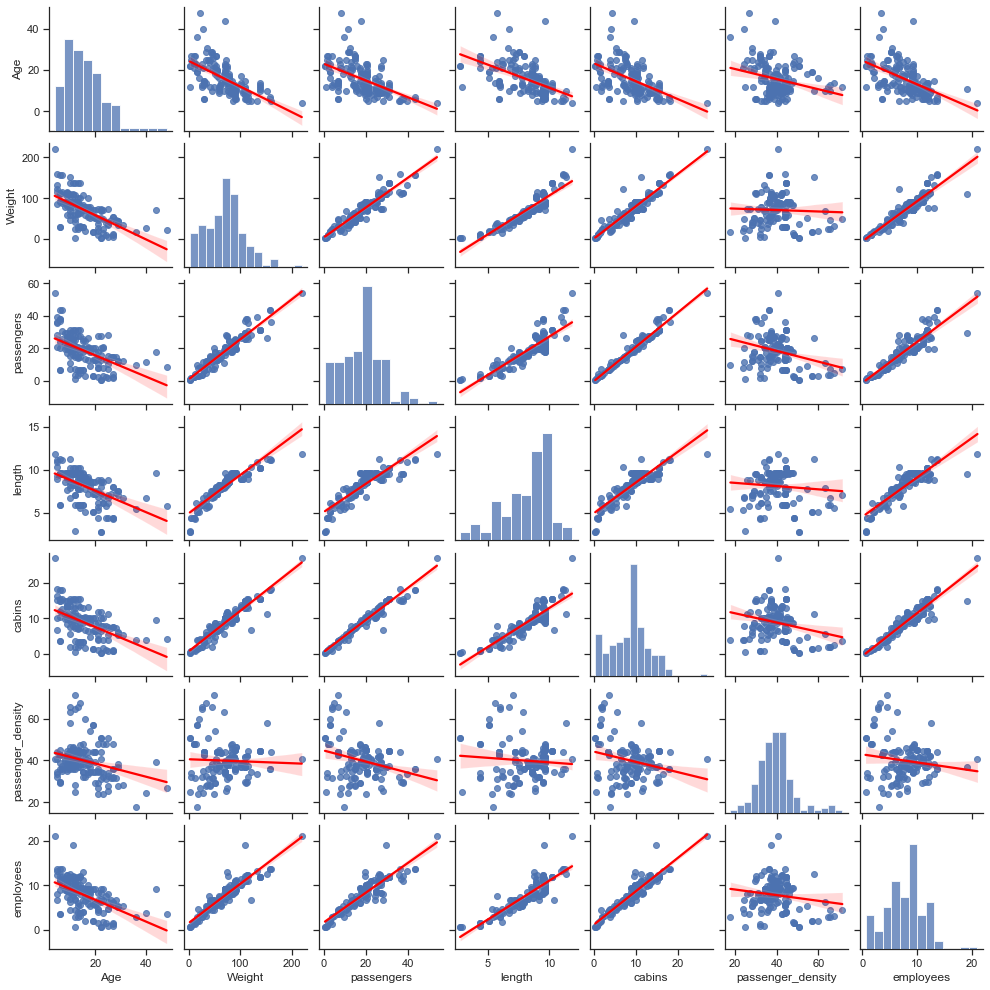

In [321]:
# Quick pair plots - Biavariate Analysis with a regression line since it is 
sns.pairplot(df, kind="reg", plot_kws={'line_kws':{'color':'red'}}, size=2)
plt.show()

Comment: <BR>
Univariate Analysis <br>
The Histograms for most variables has a a fair normal distrubution <br>
Bivariate Analysis <br>
The above pair plots indicates a strong positive correlation/relationship between the variables weight, passengers, lenght and cabins with the traget variable employees.
Age has a negative correlation. <br>
We will further explore the correlations later in the notebook and look at feature importance

In [322]:
# unique values in each feature/column
df.nunique()

Ship_name            138
Company               20
Age                   31
Weight                94
passengers           104
length                80
cabins                98
passenger_density    109
employees             91
dtype: int64

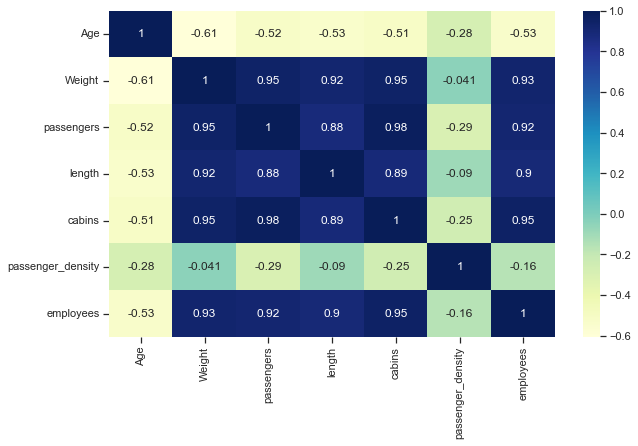

In [323]:
# Correaltion Analysis
df_corr = df.corr()
f, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(df_corr,
            annot=True,
            cmap="YlGnBu")

In [324]:
# Correlation sorted
df.corr()['employees'].sort_values()

Age                 -0.530657
passenger_density   -0.155509
length               0.895857
passengers           0.915234
Weight               0.927569
cabins               0.950823
employees            1.000000
Name: employees, dtype: float64

Comment: <BR> 
The pairplot and pearson correlation heatmap shows the # of employees is highly correlated with Length, passengers, weigh and cabins.

### Target Variable: Employees

Text(0.5, 1.0, 'Ship Employees Basic Statistics')

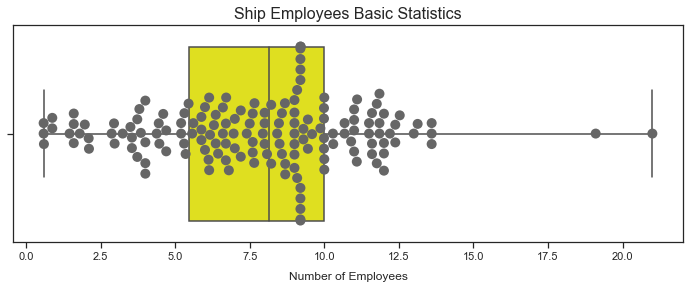

In [325]:
plt.rcParams["figure.figsize"] = [12, 4]
boxplot = sns.boxplot(x=df["employees"], data=pd.melt(df), whis=np.inf, color="yellow")
boxplot = sns.swarmplot(x=df["employees"], data=pd.melt(df),  color=".4", edgecolor="gray", size=10)
plt.xlabel("Number of Employees", fontsize="12", labelpad=10)
plt.title("Ship Employees Basic Statistics", fontsize="16")

### Regression Predictive Modeling

Our target variable "employees" is a continues variable, therefore this problem is a regressor type.
We will use two types of regressions and compare both: <br>
1- LinearRegression from sklearn <br>
2- XGBRegressor from XGBoost <br>
3- RandomForest Regressor <br>

In addition, there are two approaches either to drop the categorical column Company & ship name or to apply OneHotEncoder for both columns. This is left for debate as it requires domain knowledge, it could not be important at all or it might be important as some companies dictate minimum staff to be working on the ship.
We will experiment with the first approach only.

### Approach (Drop categorical columns):

In [326]:
df1 = df.drop(columns=['Ship_name', 'Company'])
df1.head()

,Age,Weight,passengers,length,cabins,passenger_density,employees
0,6,30.277,6.94,5.94,3.55,42.64,3.55
1,6,30.277,6.94,5.94,3.55,42.64,3.55
2,26,47.262,14.86,7.22,7.43,31.80,6.70
3,11,110.000,29.74,9.53,14.88,36.99,19.10
4,17,101.353,26.42,8.92,13.21,38.36,10.00


In [327]:
# Assign target variable to y
y = df1.pop('employees')
# Assign the rest of columns to X
X = df1.copy()

In [328]:
# Train test split using sklearn
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, test_size = 0.2, random_state = 1)

### Model 1 - XGB Regresssion

In [329]:
# Model building and fitting the model

xgb = XGBRegressor(n_estimators = 1000, learning_rate = 0.01) 
xgb.fit(X_train, y_train, eval_set = [(X_test, y_test)], verbose = False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.01, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=4, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [330]:
# XGB Predictions & Performance

prediction1 = xgb.predict(X_test) # prediction
mae1 = metrics.mean_absolute_error(prediction1, y_test) # Calculate MAE
mse1 = metrics.mean_squared_error(prediction1, y_test) # Calculate MSE
rmse1 = np.sqrt(mse1) # Calculate RMSE
mape1 = 100 * np.mean(mae1 / y_test) # Calculate MAPE, We drive mape from mae
accuracy1 = 100 - mape1


print('XGB Model Performance')
print('----------------------', end='\n')
print("Mean Absolute Error: %.2f" % mae1)
print("Mean Square Error: %.2f" % mse1)
print("Root Mean Square Error: %.2f" % rmse1)
print("Mean absolute percentage error: %.2f" % mape1)
print('Accuracy: {:0.2f}%'.format(accuracy1))

XGB Model Performance
----------------------
Mean Absolute Error: 0.34
Mean Square Error: 0.23
Root Mean Square Error: 0.48
Mean absolute percentage error: 6.48
Accuracy: 93.52%


Comment: <br>
The above metrics are used for regression problems. The less the better. A zero value of any of the above metrics is a perfect model that represents the data 100%.<br>
The metric i prefer for this problem is MAE which is easier to interpet. <br>
The mean absolute percentage error (MAPE), also known as mean absolute percentage deviation (MAPD), is a measure of prediction accuracy <br>
of a forecasting method in statistics <br>
MAPE is commonly used as a loss function for regression problems and in model evaluation, because of its very intuitive interpretation in terms of relative error.<Br>
Other regression mincludes but not limitedt ot are R-Squared and Explained Variance

### Model 2 - Linear Regresssion

In [331]:
# Model building and fitting the model

lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [332]:
# linear Regression Predictions & Performance

prediction2 = lr.predict(X_test) # predict
mae2 = metrics.mean_absolute_error(prediction2, y_test) # Calculate MAE
mse2 = metrics.mean_squared_error(prediction2, y_test) # Calculate MSE
rmse2 = np.sqrt(mse2) # Calculate RMSE
mape2 = 100 * np.mean(mae2 / y_test) # Calculate MAPE, We drive mape from mae
accuracy2 = 100 - mape2


print('LR Model Performance')
print('--------------------', end='\n')
print("Mean Absolute Error: %.2f" % mae2)
print("Mean Square Error: %.2f" % mse2)
print("Root Mean Square Error: %.2f" % rmse2)
print("Mean absolute percentage error: %.2f" % mape2)
print('Accuracy: {:0.2f}%'.format(accuracy2))

LR Model Performance
--------------------
Mean Absolute Error: 0.49
Mean Square Error: 0.42
Root Mean Square Error: 0.65
Mean absolute percentage error: 9.50
Accuracy: 90.50%


In [333]:
# Model coefficients
print('Model Coefficients: \n', lr.coef_), 
print('Model Intercept: \n', lr.intercept_)

Model Coefficients: 
 [-0.0118628   0.01797863 -0.16496357  0.34811066  0.820512   -0.00723667]
Model Intercept: 
 -0.053708079032154465


### Model 3 - Random Forest Regresssion

In [334]:
rf = RandomForestRegressor(random_state = 1)
# Train the model on training data
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=1, verbose=0, warm_start=False)

In [335]:
# Random Forest Predictions & Performance

prediction3 = rf.predict(X_test) # predict
mae3 = metrics.mean_absolute_error(prediction3, y_test) # Calculate MAE
mse3 = metrics.mean_squared_error(prediction3, y_test) # Calculate MSE
rmse3 = np.sqrt(mse3) # Calculate RMSE
mape3 = 100 * np.mean(mae3 / y_test) # Calculate MAPE, We drive mape from mae
accuracy3 = 100 - mape3


print('RF Model Performance')
print('--------------------', end='\n')
print("Mean Absolute Error: %.2f" % mae3)
print("Mean Square Error: %.2f" % mse3)
print("Root Mean Square Error: %.2f" % rmse3)
print("Mean absolute percentage error: %.2f" % mape3)
print('Accuracy: {:0.2f}%'.format(accuracy3))

RF Model Performance
--------------------
Mean Absolute Error: 0.35
Mean Square Error: 0.23
Root Mean Square Error: 0.48
Mean absolute percentage error: 6.70
Accuracy: 93.30%


In [336]:
rf.feature_importances_

array([0.01598847, 0.34230711, 0.06191289, 0.04246364, 0.52349577,
       0.01383211])

### Model metric plot comparison

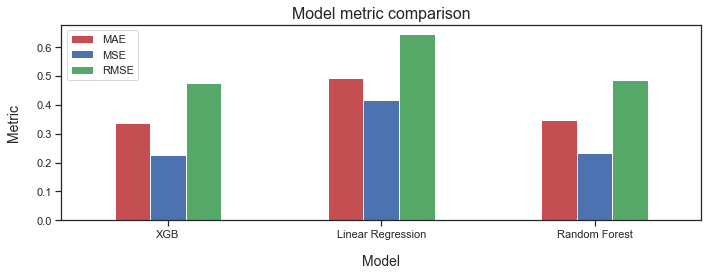

In [337]:
plotdata = pd.DataFrame({
    "MAE":[mae1, mae2, mae3],
    "MSE":[mse1, mse2, mse3],
    "RMSE":[rmse1, rmse2, rmse3],
    #"MAPE":[mape1, mape2, mape3],
    #"ACCURACY":[accuracy1, accuracy2, accuracy3]
    
    }, 
    index=["XGB", "Linear Regression", "Random Forest"]
)


plt.rcParams["figure.figsize"] = [10, 4]
plotdata.plot(kind="bar", color=['r', 'b', 'g'])
plt.title("Model metric comparison", fontsize="16")
plt.xticks(rotation='horizontal')
plt.xlabel("Model", fontsize="14", labelpad=15)
plt.ylabel("Metric", fontsize="14", labelpad=15)
plt.legend(loc="upper left")
plt.tight_layout()

Comment: <BR>
The performance of Random Forest & XGB models were much better than the Linear Regression model. We will choose Random forest<Br>
The three mertics displayed above has different uses depending on the case. RMSE is less intuitive to understand, but extremely common. It penalizes really bad predictions.
MAE is straightforward to understand and treats all prediction errors proportionately. We would prefer it in most regression problems.

### Random Forest Optimization

We will use Cross Validation and hyperparameter tuning for our model. We will use K Fold CV for Cross Validation. In KFold cv we will spit the training set into K number of susbtets called folds. 
We will fit the model K times, each time training the data on K-1 of the folds and evaluating on the Kth fold.
The best approach will be random search to narrow our search to evaluate a wide range of hyperparameter values. Using Scikit-Learn’s RandomizedSearchCV method, we can define a grid of hyperparameter ranges, and randomly sample from the grid, performing K-Fold CV with each combination of values.

In [338]:
#rf = RandomForestRegressor(random_state = 0)
# print the parameters for RF
print('Parameters in use:\n')
pprint(rf.get_params())

Parameters in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}


In [355]:
# Parameters
bootstrap = [True, False] # Sampling methods
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1500, num = 20)] # Number of trees
max_depth = [int(x) for x in np.linspace(5, 50, num = 5)] # Tree Depth
max_depth.append(None)
min_samples_leaf = [1, 2, 3] # Leaf node samples
min_samples_split = [2, 3, 4] # min number of observations require to split at node

# Create a random grid
grid = {'bootstrap': bootstrap,
        'n_estimators': n_estimators,
        'max_depth': max_depth,
        'min_samples_leaf': min_samples_leaf,
        'min_samples_split': min_samples_split
        }

pprint(grid)

{'bootstrap': [True, False],
 'max_depth': [5, 16, 27, 38, 50, None],
 'min_samples_leaf': [1, 2, 3],
 'min_samples_split': [2, 3, 4],
 'n_estimators': [100,
                  173,
                  247,
                  321,
                  394,
                  468,
                  542,
                  615,
                  689,
                  763,
                  836,
                  910,
                  984,
                  1057,
                  1131,
                  1205,
                  1278,
                  1352,
                  1426,
                  1500]}


Comment: <BR>
There are 2,160 combination parameter settings. <br>
It would take a very long to train all combinations using grid search, therefore we will use Random Search instead whicH selectS randomly from our combinations. The number of combinations is determined by n_iter.

In [356]:
# Training with 4 workers in parallel
# Random search with 3 fold cross validation, and use of 200 combinations. Then will fit the model (600 fits)

rf_cv = RandomizedSearchCV(estimator = rf, param_distributions = grid, cv = 3, n_iter = 200, random_state=1, n_jobs = -1, verbose=2)
rf_cv.fit(X_train, y_train)

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  4.3min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [357]:
# best PARAMS
rf_cv.best_params_

{'n_estimators': 542,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_depth': 16,
 'bootstrap': False}

Comment: <br>
 The above parameter values are the best combination for our RF optimized model. This combinatrion achieved the lowest error based on the mse criterion.

In [362]:
# Predictions & Performance

prediction4 = rf_cv.predict(X_test) # predict
mae4 = metrics.mean_absolute_error(prediction4, y_test) # Calculate MAE
mse4 = metrics.mean_squared_error(prediction4, y_test) # Calculate MSE
rmse4 = np.sqrt(mse4) # Calculate RMSE
mape4 = 100 * np.mean(mae4 / y_test) # Calculate MAPE, We drive mape from mae
accuracy4 = 100 - mape4

print('RF Model Performance')
print('--------------------', end='\n')
print("Mean Absolute Error: %.2f" % mae4)
print("Mean Square Error: %.2f" % mse4)
print("Root Mean Square Error: %.2f" % rmse4)
print("Mean absolute percentage error: %.2f" % mape4)
print('Accuracy: {:0.2f}%'.format(accuracy4))

RF Model Performance
--------------------
Mean Absolute Error: 0.27
Mean Square Error: 0.20
Root Mean Square Error: 0.44
Mean absolute percentage error: 5.12
Accuracy: 94.88%


Comment: <br>
The optimized model's accuracy on the test set increased by 1.5% <br>
The high accuracy on the test set indicates that our model generalized very well. 

### Random Forest optimization metric plot

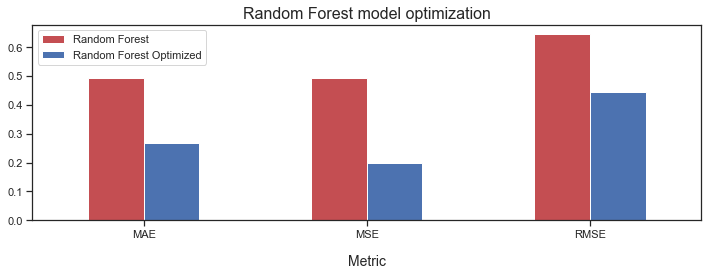

In [343]:
plotdata = pd.DataFrame({
    "Random Forest":[mae2, mae2, rmse2],
    "Random Forest Optimized":[mae4, mse4, rmse4],
    }, 
    index=["MAE", "MSE", "RMSE"]
)

plt.rcParams["figure.figsize"] = [10, 4]
plotdata.plot(kind="bar", color=['r', 'b'])
plt.title("Random Forest model optimization", fontsize="16")
plt.xticks(rotation='horizontal')
plt.xlabel("Metric", fontsize="14", labelpad=15)
plt.tight_layout()

Comment: <br>
We see an improvement on our RF model across all metrics. The bars in blue are the optimized model after hyperparamter tuning. <br>
The goal is to decrease the metric value.

### Feature Importance with SHAP

Shap is a method that computes feature importance. It uses the Shapley values from game theory to estimate how does each feature contribute to the prediction.
We can use XGB or Random Forest models to extract the shap values as both are based on tree models.

In addition to shap we can plot feature imnportance from the xgb and random forest tree model built in function as well. 

In [344]:
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)

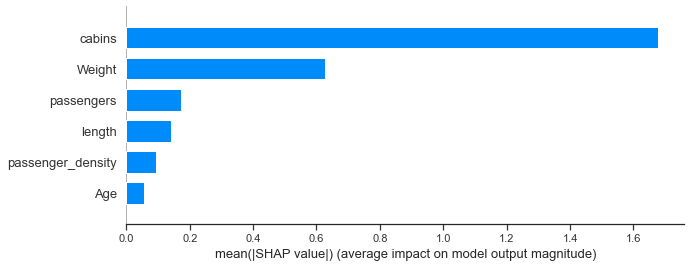

In [345]:
shap.summary_plot(shap_values, X_test, plot_type="bar", plot_size=(10,4))

According to Shap the most important feature that contributes strongly to the predictive model is cabins and it is more than dpuble in importance of the <br>
second feature which is weight of the ship. 

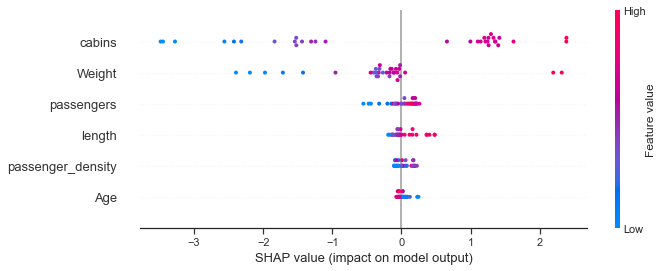

In [346]:
shap.summary_plot(shap_values, X_test, plot_size=(10,4))

The beeswarm plot is designed to display an information-dense summary of how the top features in a dataset impact the model's output.

Conclusion:
    
This is a basic EDA and modeling. <br><Br>
We applied EDA and built 3 models to compare. The dataset did not have any NULL or duplicated values. We did basic charts and did not include and distrubution or density plots. Generally the features were not skewed heavily and has fairly normal ditrubutions so no need for any logarithmic transformations. In addition, there wasn't heavy outliers. <br>

We choose Random forest to optimize, we applied cross validation and random search for parameters hyper tuning. <br> We can also plots\ test and train error plots by collecting the scores in a loop and ploting them.

The most important feature for the random forest model was cabins followed by weight of the ship. Age, according to the model wasn't important enough for predicting number of employee for ships. This was confirmed by the model built in method and Shap.<Br>

We used only one approach which is dropping all categorical columns namely Ship name and company which most probably will not add value to the models. Another approach we can use is hot encoding to encode the categorical columns so it can be fed to the model. 